In [40]:
from numpy import mean, std
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [41]:
# define date range
start_date = '2005-01-22'
end_date  = datetime.today().strftime('%Y-%m-%d')


In [42]:
diction = {'Gold': 'GC=F', 'US treas bonds':'QLTA', '10y': '^TNX','sp500': 'SPY'}

for i in diction:
    print(diction[i])

GC=F
QLTA
^TNX
SPY


In [43]:
# retrieve markets

data = yf.download(['GC=F', 'QLTA', '^TNX', 'SPY'], start_date, end_date)
print(data)

[*********************100%***********************]  4 of 4 completed
              Adj Close                                      Close             \
                   GC=F       QLTA         SPY   ^TNX         GC=F       QLTA   
Date                                                                            
2005-01-24   426.899994        NaN   82.248032  4.122   426.899994        NaN   
2005-01-25   422.000000        NaN   82.480911  4.189   422.000000        NaN   
2005-01-26   426.899994        NaN   82.727882  4.192   426.899994        NaN   
2005-01-27   426.299988        NaN   82.869019  4.207   426.299988        NaN   
2005-01-28   425.799988        NaN   82.869019  4.138   425.799988        NaN   
...                 ...        ...         ...    ...          ...        ...   
2023-03-02  1833.500000  46.099998  397.809998  4.073  1833.500000  46.099998   
2023-03-03  1847.699951  46.560001  404.190002  3.964  1847.699951  46.560001   
2023-03-06  1847.900024  46.430000  404.

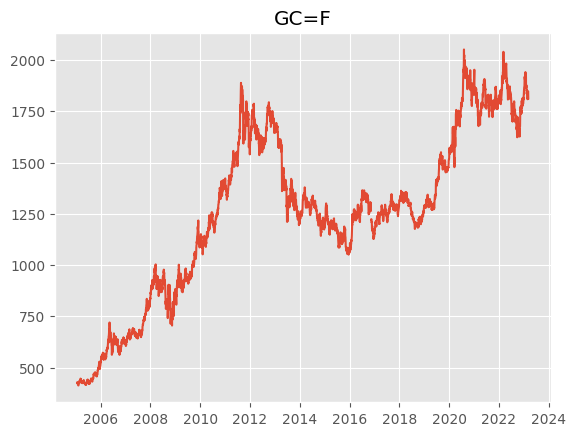

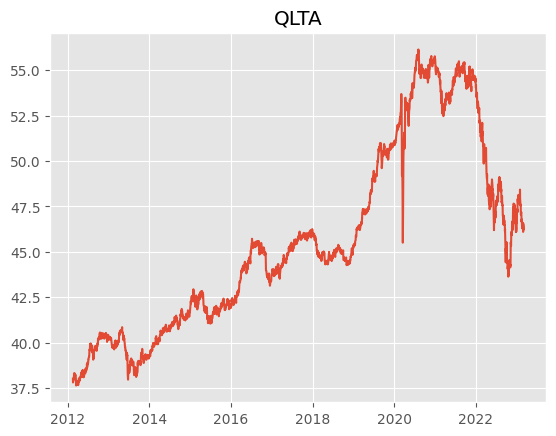

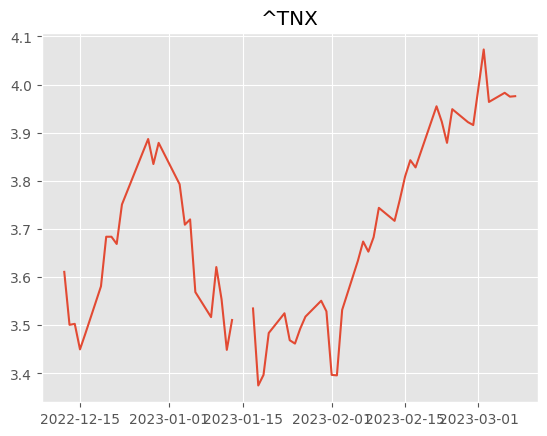

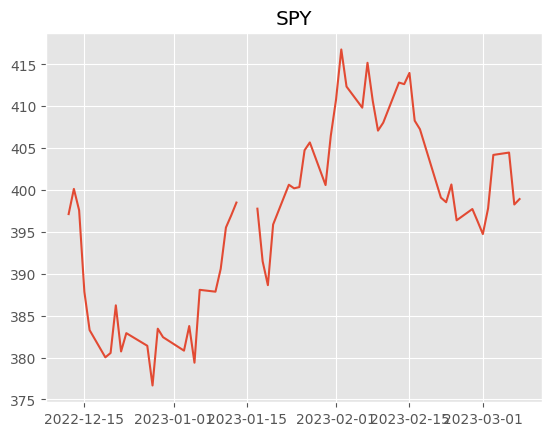

In [44]:
plt.plot(data[('Adj Close', 'GC=F')])
plt.title('GC=F')
plt.show()

plt.plot(data[('Adj Close', 'QLTA')])
plt.title('QLTA')
plt.show()

plt.plot(data[('Adj Close', '^TNX')][-60:])
plt.title('^TNX')
plt.show()

plt.plot(data[('Adj Close', 'SPY')][-60:])
plt.title('SPY')
plt.show()

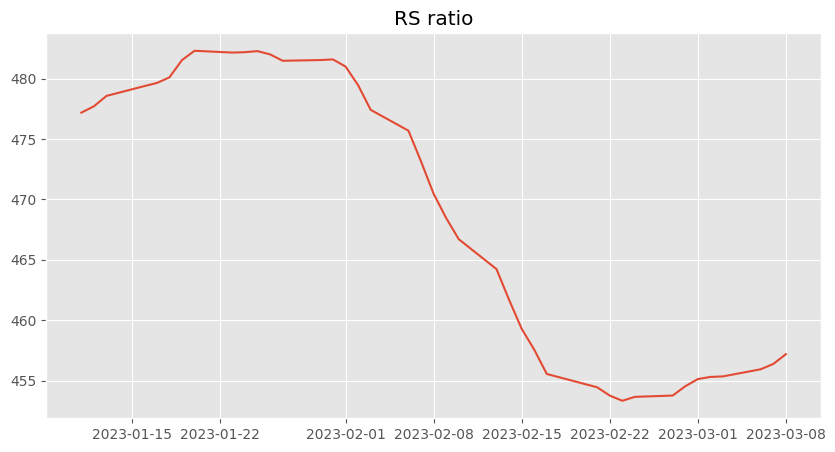

In [52]:
# simple rs ratio

def rs_ratio(prices_df, benchmark, window=14):
    
    """
    Function that returns dataframe with relative strength ratio for each symbol
    """


    ratio_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        
        rs = (prices_df[column] / benchmark) * 100
        rs = rs.rolling(window).mean() 
            
        ratio_df[f'{column}_ratio'] = rs
    ratio_df.dropna(axis=0, how='all', inplace=True)
    
    return ratio_df


ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])
#plt.plot(data[('Adj Close', '^TNX')])

#plt.figure(figsize=[10, 5])
#plt.plot(ratio_df['^TNX_ratio'])
#plt.title('RS ratio')
#plt.show()
plt.figure(figsize=[10, 5])
plt.plot(ratio_df['GC=F_ratio'][-40:])
plt.title('RS ratio')
plt.show()

C:\Users\pietr\AppData\Local\Temp\ipykernel_11532\2428972461.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_df[series]=  prices_df[series].rolling(4).mean()
C:\Users\pietr\AppData\Local\Temp\ipykernel_11532\2428972461.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_df[series] = rel_ratio
C:\Users\pietr\AppData\Local\Temp\ipykernel_11532\2428972461.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

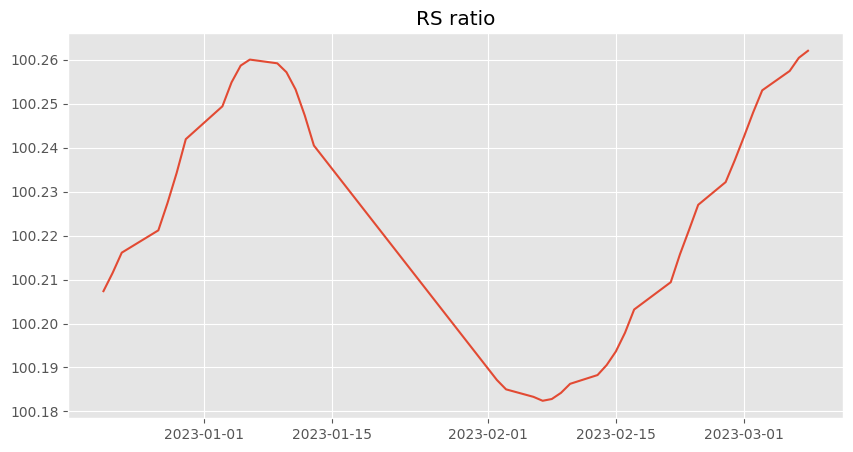

In [47]:
from numpy import mean, std



def rs_ratio(prices_df, benchmark, window=10):
    benchmark = benchmark.rolling(4).mean()
    
    for series in prices_df:
        prices_df[series]=  prices_df[series].rolling(4).mean()
        rs = (prices_df[series].divide(benchmark)) * 100
        rs_ratio = rs.rolling(window).mean()
        rel_ratio = 100 + ((rs_ratio - rs_ratio.mean()) / rs_ratio.std() + 1)
        prices_df[series] = rel_ratio
    prices_df.dropna(axis=0, how='all', inplace=True)
    return prices_df

ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])
#plt.plot(data[('Adj Close', '^TNX')])

#plt.figure(figsize=[10, 5])
#plt.plot(ratio_df['^TNX_ratio'])
#plt.title('RS ratio')
#plt.show()
plt.figure(figsize=[10, 5])
plt.plot(ratio_df['^TNX'][-40:])
plt.title('RS ratio')
plt.show()

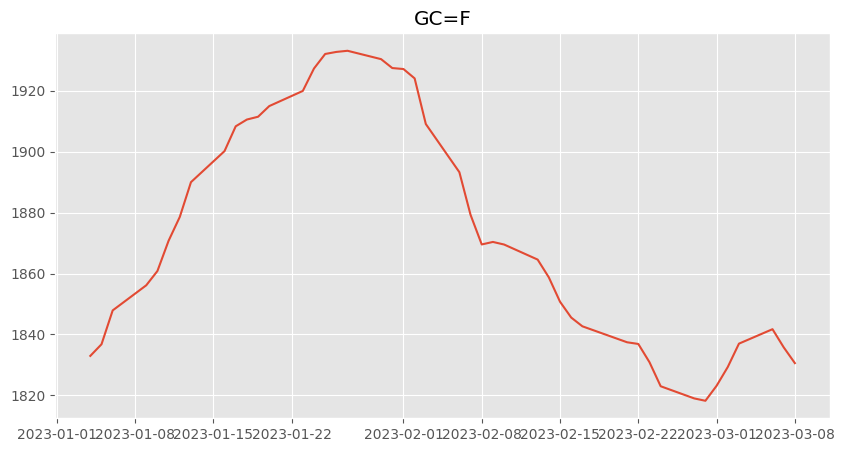

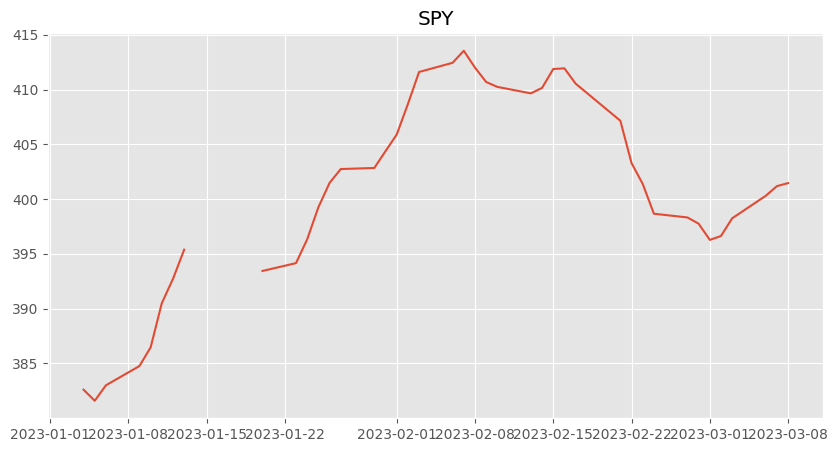

In [48]:
plt.figure(figsize=[10, 5])
plt.plot(data[('Adj Close', 'GC=F')][-48:].rolling(4).mean())
plt.title('GC=F')
plt.show()

plt.figure(figsize=[10, 5])
plt.plot(data[ ('Adj Close', 'SPY')][-48:].rolling(4).mean())
plt.title('SPY')
plt.show()



C:\Users\pietr\AppData\Local\Temp\ipykernel_11532\493434476.py:26: RuntimeWarning: invalid value encountered in double_scalars
  ratio = (rs_subset[i] - rs_subset[-window * 2 : i-1].mean()) / rs_subset[-window * 2 : i-1].std()


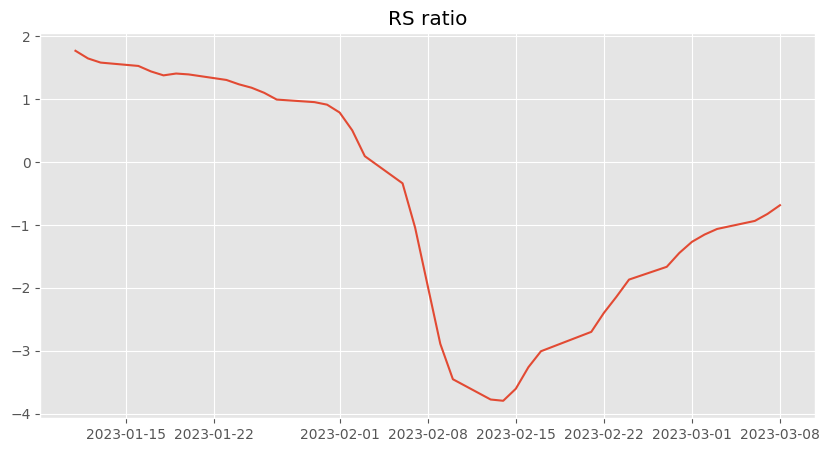

In [50]:
# rs ratio (rate)


def rs_ratio(prices_df, benchmark, window=14):
    
    """
    Function that returns dataframe with relative strength ratio for each symbol
    """
    index = prices_df.index

    ratio_df = pd.DataFrame(index=index)
    ratio_df.index = pd.to_datetime(ratio_df.index)
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        
        rs = (prices_df[column] / benchmark) * 100
        rs = rs.rolling(window).mean()
        rs_ratio = [np.nan for i in range(window * 2)]
        
        for i in range(window * 2, len(rs)):
            rs_subset = rs[: i+1]                 
            ratio = (rs_subset[i] - rs_subset[-window * 2 : i-1].mean()) / rs_subset[-window * 2 : i-1].std()
            rs_ratio.append(ratio)    
            
        ratio_df[f'{column}_ratio'] = rs_ratio
        
    ratio_df.dropna(axis=0, how='all', inplace=True)
    
    return ratio_df


ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])
#plt.plot(data[('Adj Close', '^TNX')])

#plt.figure(figsize=[10, 5])
#plt.plot(ratio_df['^TNX_ratio'])
#plt.title('RS ratio')
#plt.show()
plt.figure(figsize=[10, 5])
plt.plot(ratio_df['GC=F_ratio'][-40:])
plt.title('RS ratio')
plt.show()

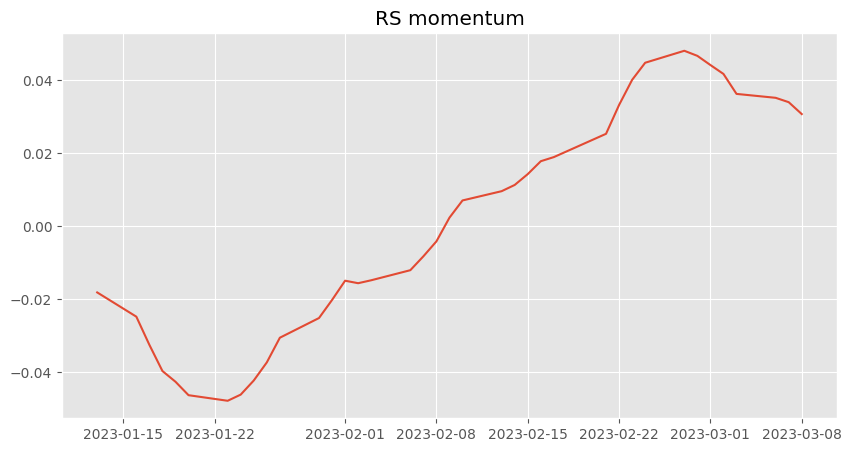

In [20]:
# relative strength momentum simple

def rs_momentum(prices_df, benchmark, window=14):
    """
    Function to return dataframe with relative strength momentum for each symbol
    """
    
    momentum_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        
        rs = (prices_df[column][-window*4:] / benchmark[-window*4:]) * 100
        
        rs_ratio = rs.rolling(window).mean()
        
        rs_momentum = rs_ratio - rs_ratio.shift(5)
        
        #rel_momentum = 100 + ((rs_momentum - rs_momentum.mean()) / rs_momentum.std() + 1)
        #rel_momentum = 100 + ((rs_momentum - rs_momentum.mean()) / rs_momentum.std())
        
        momentum_df[f'{column}_momentum'] = rs_momentum
        
    momentum_df.dropna(axis=0, how='all', inplace=True)
    
    return momentum_df

momentum_df = rs_momentum(data['Adj Close'], data[('Adj Close', 'SPY')])
plt.figure(figsize=[10, 5])
plt.plot(momentum_df['^TNX_momentum'][-40:])
plt.title('RS momentum')
plt.show()

C:\Users\pietr\AppData\Local\Temp\ipykernel_11532\3110044187.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ratio = (rs_subset[i] - rs_subset[-window * 2 : i-1].mean()) / rs_subset[-window * 2 : i-1].std()


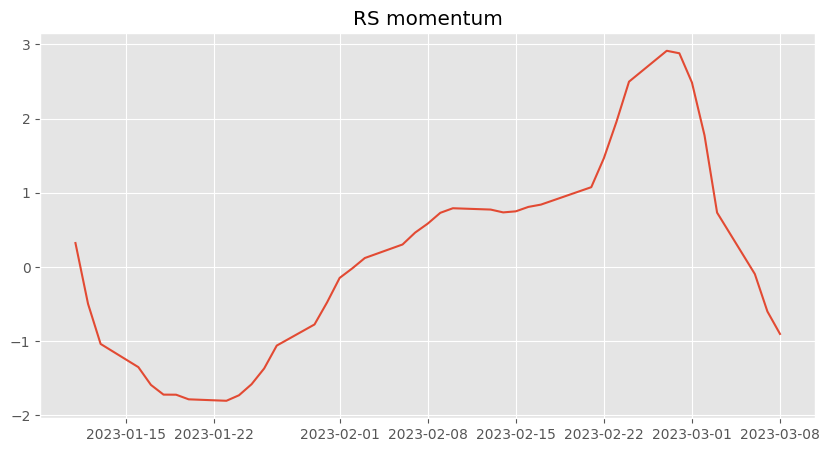

In [21]:
# trial dashboard






def rs_momentum(prices_df, benchmark, window=14):
    """
    Function that returns dataframe with relative strength momentum for each symbol
    """
    # create new dataframe
    index = prices_df.index

    momentum_df = pd.DataFrame(index=index)
    momentum_df.index = pd.to_datetime(momentum_df.index)
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        
        rs = (prices_df[column] / benchmark) * 100
        rs = rs.rolling(window).mean()
        rs_ratio = [np.nan for i in range(window * 2)]
        
        for i in range(window * 2, len(rs)):
            rs_subset = rs[: i+1]                 
            ratio = (rs_subset[i] - rs_subset[-window * 2 : i-1].mean()) / rs_subset[-window * 2 : i-1].std()
            rs_ratio.append(ratio) 
            
        rs_ratio = pd.Series(rs_ratio, index = index)
        rs_momentum = pd.Series(rs_ratio) - pd.Series(rs_ratio).shift(5)
   
        momentum_df[f'{column}_momentum'] = rs_momentum
        
    momentum_df.dropna(axis=0, how='all', inplace=True)
    
    return momentum_df

momentum_df = rs_momentum(data['Adj Close'], data[('Adj Close', 'SPY')])
plt.figure(figsize=[10, 5])
plt.plot(momentum_df['^TNX_momentum'][-40:])
plt.title('RS momentum')
plt.show()

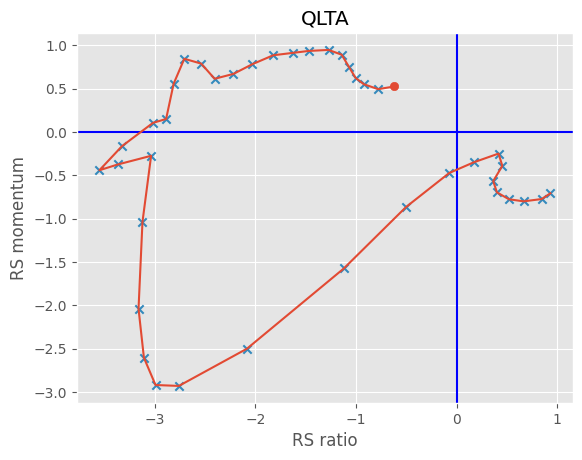

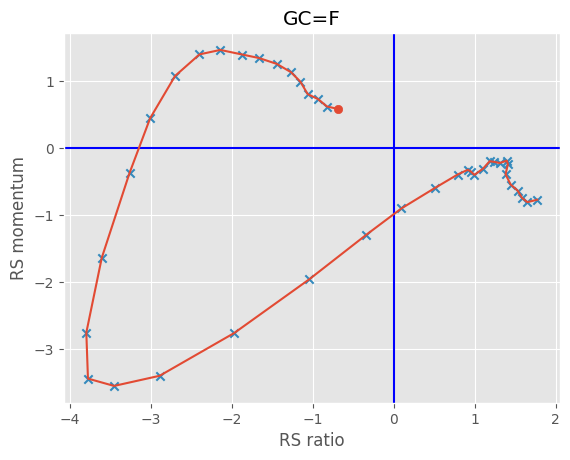

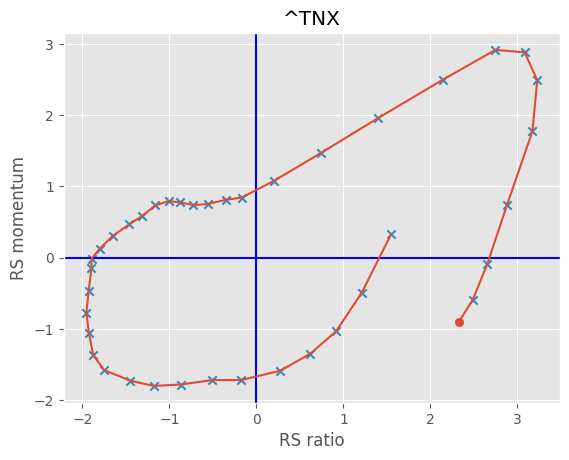

In [22]:
def rrg_plot(df, symbol, period = 20):
    """
    Method to visualize RRG plot for one market/symbol. The benchmark is SPY
    """
    df = df.copy()
    df =df.iloc[-period:]
    
    last = df.iloc[-1]    
    others = df.iloc[:-1]    

    plt.axvline(x = 0, color = 'b')
    plt.axhline(y = 0, color = 'b')

    plt.plot(df[f'{symbol}_ratio'], df[f'{symbol}_momentum'])
    plt.scatter(last[f'{symbol}_ratio'], last[f'{symbol}_momentum'], marker='o')
    plt.scatter(others[f'{symbol}_ratio'], others[f'{symbol}_momentum'], marker='x')

    plt.title(symbol)
    plt.xlabel("RS ratio")
    plt.ylabel("RS momentum")

    plt.show()
    
df = pd.merge(ratio_df, momentum_df, left_on=ratio_df.index, right_on=momentum_df.index).set_index('key_0')

rrg_plot(df, 'QLTA', 40)
rrg_plot(df, 'GC=F', 40)
rrg_plot(df, '^TNX', 40)




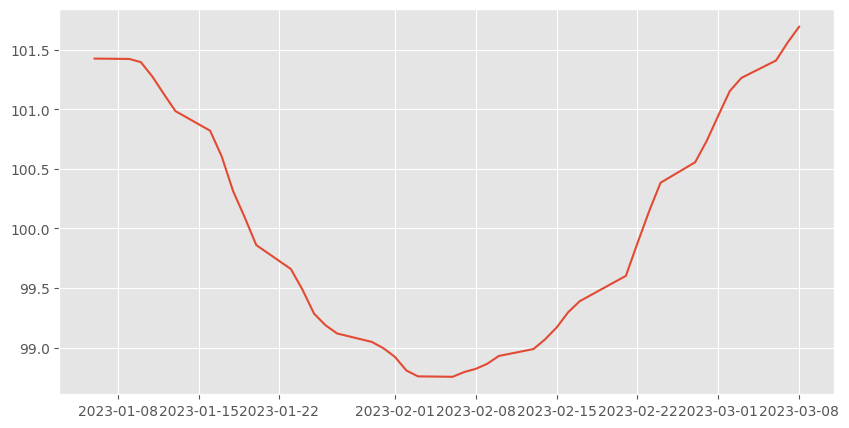

In [23]:
# rs ratio window only
def rs_ratio(prices_df, benchmark, window=14):
    """
    Function to return dataframe with relative strength ratio for each symbol
    """
    
    ratio_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        rs = (prices_df[column][-window*4:] / benchmark[-window*4:]) * 100
        rs_ratio = rs.rolling(window).mean()
        #rel_ratio = 100 + ((rs_ratio - rs_ratio.mean()) / rs_ratio.std() + 1)
        
        rel_ratio = 100 + ((rs_ratio - rs_ratio.mean()) / rs_ratio.std())

        ratio_df[f'{column}_ratio'] = rel_ratio
        
    ratio_df.dropna(axis=0, how='all', inplace=True)
    
    return ratio_df

ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])
plt.figure(figsize=[10, 5])

plt.plot(ratio_df['^TNX_ratio'])

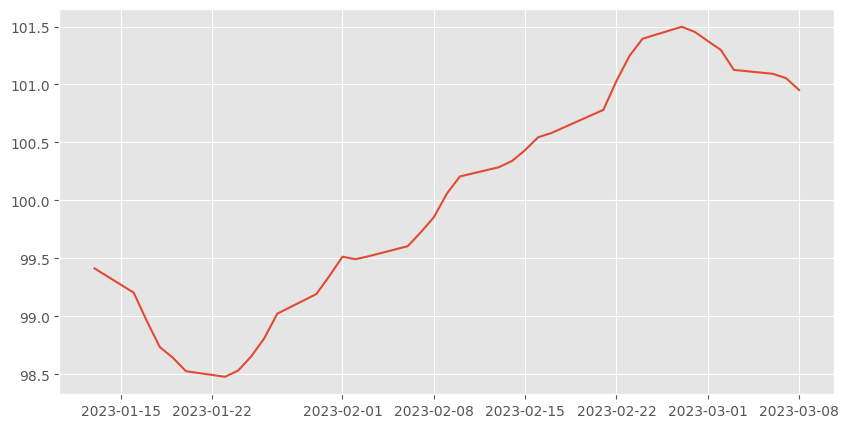

In [24]:
# momentum window only

def rs_momentum(prices_df, benchmark, window=14):
    """
    Function to return dataframe with relative strength momentum for each symbol
    """
    
    momentum_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        
        rs = (prices_df[column][-window*4:] / benchmark[-window*4:]) * 100
        
        rs_ratio = rs.rolling(window).mean()
        
        rs_momentum = rs_ratio - rs_ratio.shift(5)
        
  
        #rel_momentum = 100 + ((rs_momentum - rs_momentum.mean()) / rs_momentum.std() + 1)
        rel_momentum = 100 + ((rs_momentum - rs_momentum.mean()) / rs_momentum.std())
        
        momentum_df[f'{column}_momentum'] = rel_momentum
        
    momentum_df.dropna(axis=0, how='all', inplace=True)
    
    return momentum_df

momentum_df = rs_momentum(data['Adj Close'], data[('Adj Close', 'SPY')])
plt.figure(figsize=[10, 5])

plt.plot(momentum_df['^TNX_momentum'])

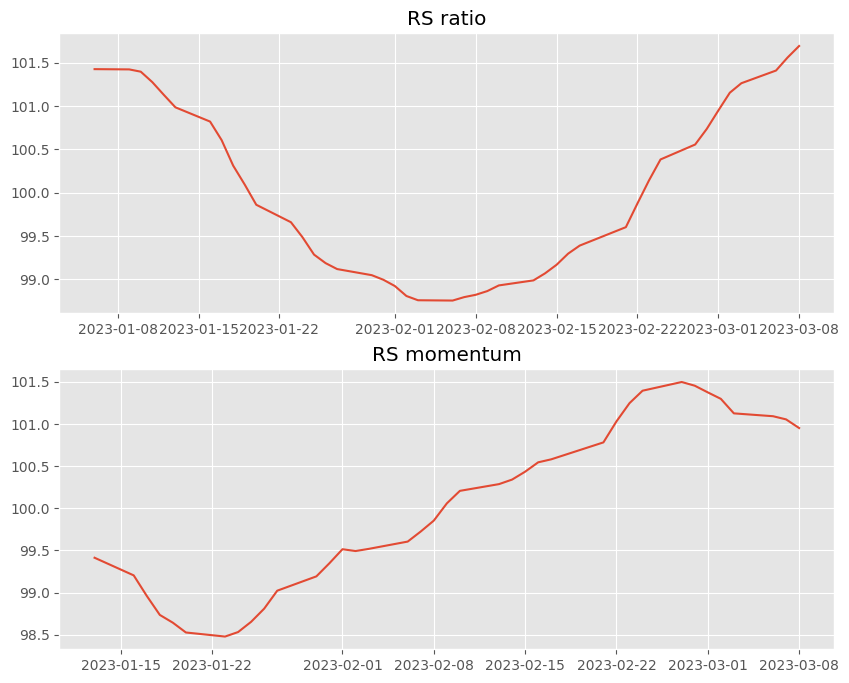

In [25]:
def visualize_rs(symbol:str):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(ratio_df[f'{symbol}_ratio'], label=ratio_df.columns)
    ax[0].set_title('RS ratio')
    #ax[0].legend()

    ax[1].plot(momentum_df[f'{symbol}_momentum'], label=momentum_df.columns)
    ax[1].set_title('RS momentum')
    #ax[1].legend()
    plt.show()
    
visualize_rs('^TNX')

In [26]:
# merge rs ratio and momentum data
df = pd.merge(ratio_df, momentum_df, left_on=ratio_df.index, right_on=momentum_df.index).set_index('key_0')

print(df[-5:])

            GC=F_ratio  QLTA_ratio  SPY_ratio  ^TNX_ratio  GC=F_momentum  \
key_0                                                                      
2023-03-02   98.760777   98.853833        NaN  101.154099     100.854820   
2023-03-03   98.764597   98.850464        NaN  101.263673     100.803878   
2023-03-06   98.816235   98.864006        NaN  101.410030     100.891779   
2023-03-07   98.854531   98.924234        NaN  101.560279     100.832419   
2023-03-08   98.925210   98.995427        NaN  101.693147     100.870782   

            QLTA_momentum  SPY_momentum  ^TNX_momentum  
key_0                                                   
2023-03-02     101.406119           NaN     101.297890  
2023-03-03     101.335119           NaN     101.125804  
2023-03-06     101.342225           NaN     101.092053  
2023-03-07     101.308526           NaN     101.054450  
2023-03-08     101.447384           NaN     100.951837  


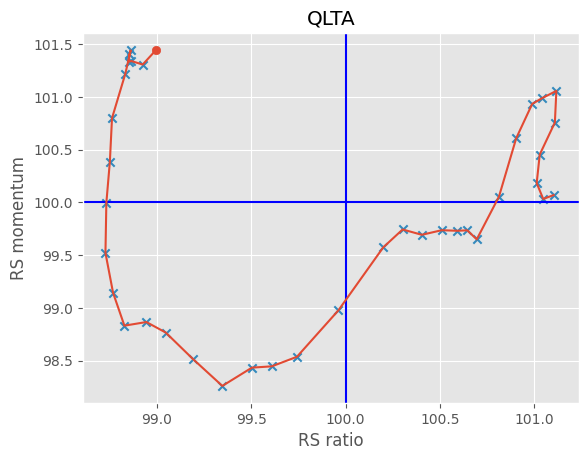

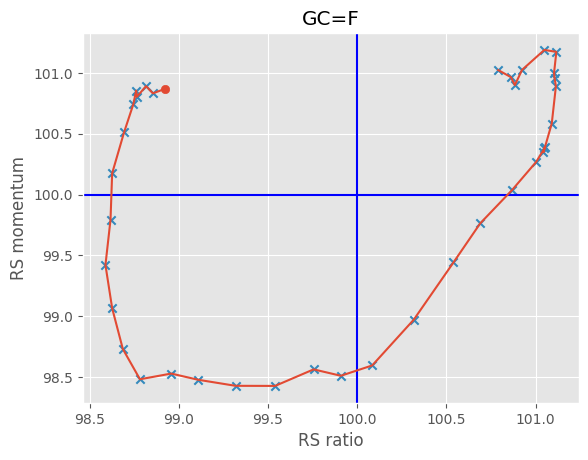

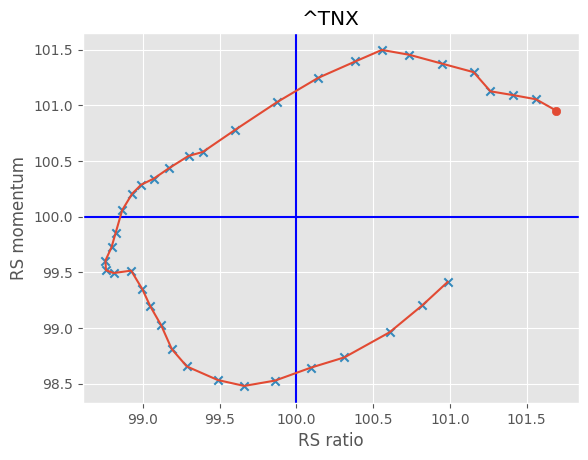

In [27]:
def rrg_plot(df, symbol, period = 20):
    """
    Method to visualize RRG plot for one market/symbol. The benchmark is SPY
    """
    df = df.copy()
    df =df.iloc[-period:]
    
    last = df.iloc[-1]    
    others = df.iloc[:-1]    

    plt.axvline(x = 100, color = 'b')
    plt.axhline(y = 100, color = 'b')

    plt.plot(df[f'{symbol}_ratio'], df[f'{symbol}_momentum'])
    plt.scatter(last[f'{symbol}_ratio'], last[f'{symbol}_momentum'], marker='o')
    plt.scatter(others[f'{symbol}_ratio'], others[f'{symbol}_momentum'], marker='x')

    plt.title(symbol)
    plt.xlabel("RS ratio")
    plt.ylabel("RS momentum")

    plt.show()
    

rrg_plot(df, 'QLTA', 40)
rrg_plot(df, 'GC=F', 40)
rrg_plot(df, '^TNX', 40)




In [ ]:
# rs momentum for dashboard

def rs_momentum(prices_df, benchmark, window=14):
    """
    Function that returns dataframe with relative strength momentum for each symbol
    """
    # create new dataframe
    index = prices_df.index

    momentum_df = pd.DataFrame(index=index)
    momentum_df.index = pd.to_datetime(momentum_df.index)
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    benchmark = benchmark.rolling(4).mean()

    for column in prices_df:
        prices_df[column] = prices_df[column].rolling(4).mean()

        rs = (prices_df[column] / benchmark) * 100
        #rs = rs.rolling(window).mean()
        rs_ratio = [np.nan for i in range(window * 2)]
        
        for i in range(window * 2, len(rs)):
            rs_subset = rs[: i+1]                 
            ratio = (rs_subset[i] - rs_subset[-window * 2 : i-1].mean()) / rs_subset[-window * 2 : i-1].std()
            rs_ratio.append(ratio) 
            
        rs_ratio = pd.Series(rs_ratio, index= index)
        rs_ratio = rs_ratio.rolling(4).mean()

        rs_momentum = pd.Series(rs_ratio) - pd.Series(rs_ratio).shift(1)
   
        momentum_df[f'{column}_momentum'] = rs_momentum
        
    momentum_df.dropna(axis=0, how='all', inplace=True)
    
    return momentum_df
